# Topic 3 – Filtering in Time and Frequency

*DSP for Audio – Offline Notebook*

**Dataset folder:** `audio_dataset/`


Offline lab: FIR moving average + FFT-domain notch filtering.


## Setup


In [9]:
import os

REPO_URL = "https://github.com/fabioantonacci79/BasicDSP.git"
REPO_NAME = "BasicDSP"

if not os.path.exists(REPO_NAME):
    !git clone {REPO_URL}

%cd BasicDSP/notebooks

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from pathlib import Path
import ipywidgets as widgets
from IPython.display import Audio, display

DATA_DIR = Path('/content/BasicDSP/notebooks/audio_dataset')
SR_DEFAULT = 16000

def load_wav(path):
    sr, x = wavfile.read(path)
    # Convert to float in [-1, 1]
    if x.dtype == np.int16:
        x = x.astype(np.float32) / 32768.0
    elif x.dtype == np.int32:
        x = x.astype(np.float32) / 2147483648.0
    else:
        x = x.astype(np.float32)
    if x.ndim > 1:
        x = x.mean(axis=1)  # mono
    return sr, x

def save_wav(path, sr, x):
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -1, 1)
    wavfile.write(path, sr, (x * 32767).astype(np.int16))

def play(x, sr):
    display(Audio(x, rate=sr))

def plot_time(x, sr, title='Time signal', seconds=0.05):
    n = min(len(x), int(seconds*sr))
    tt = np.arange(n)/sr
    plt.figure()
    plt.plot(tt, x[:n])
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_spectrum(x, sr, title='Magnitude spectrum'):
    N = len(x)
    w = np.hanning(N)
    X = np.fft.rfft(x*w)
    f = np.fft.rfftfreq(N, d=1/sr)
    mag = 20*np.log10(np.abs(X)+1e-12)
    plt.figure()
    plt.plot(f, mag)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.title(title)
    plt.grid(True)
    plt.xlim(0, sr/2)
    plt.show()


## 3.1 Time-domain filtering: moving average (FIR) on short signals: visualization of the effect of convolution


In [4]:
# ----------------------------
# Signal and filter definition
# ----------------------------
N = 16                    # x[n] defined for n=0..15
a = 0.80                  # exponential decay factor
M = 5                     # moving average length (causal)

n_x = np.arange(N)
x = (a ** n_x)            # x[n] for n>=0, truncated at n=15

n_h = np.arange(M)
h = np.ones(M) / M        # h[n] = 1/M for n=0..M-1

# Convolution (full)
y = np.convolve(x, h, mode="full")
n_y = np.arange(len(y))

# Zero-padded h[n] at lag 0 (for plotting)
h0 = np.zeros_like(y, dtype=float)
h0[:M] = h

# Zero-padded x[n] (for product visualization)
x_pad = np.zeros_like(y, dtype=float)
x_pad[:N] = x

# ----------------------------
# Interactive visualization
# ----------------------------
n0_slider = widgets.IntSlider(
    value=0, min=0, max=len(y)-1, step=1,
    description="n₀", continuous_update=True
)

def update(n0):
    # Build flipped+shifted version h[n0 - n]
    h_shift = np.zeros_like(y, dtype=float)
    for n in range(len(y)):
        idx = n0 - n
        if 0 <= idx < M:
            h_shift[n] = h[idx]

    # Pointwise product
    product = x_pad * h_shift

    fig, axes = plt.subplots(4, 1, figsize=(10, 12), constrained_layout=True)

    # ---- Plot 1: x[n]
    ax = axes[0]
    ax.stem(n_x, x, basefmt=" ")
    ax.set_title("Input signal x[n] (causal exponential, truncated at n=15)")
    ax.set_xlabel("n")
    ax.set_ylabel("Amplitude")
    ax.set_xlim(-1, len(y))

    # ---- Plot 2: h[n] and h[n0-n]
    ax = axes[1]
    ax.stem(n_y, h0, basefmt=" ", linefmt="C0-", markerfmt="C0o", label="h[n] (lag 0)")
    ax.stem(n_y, h_shift, basefmt=" ", linefmt="C1-", markerfmt="C1o", label=f"h[n₀-n] (n₀={n0})")
    ax.set_title("Moving average filter: original and flipped+shifted")
    ax.set_xlabel("n")
    ax.set_ylabel("Amplitude")
    ax.set_xlim(-1, len(y))
    ax.legend(loc="upper right")

    # ---- Plot 3: pointwise product
    ax = axes[2]
    ax.stem(n_y, product, basefmt=" ")
    ax.set_title(r"Pointwise product $x[n]\;h[n_0-n]$ (terms summed in convolution)")
    ax.set_xlabel("n")
    ax.set_ylabel("Amplitude")
    ax.set_xlim(-1, len(y))
    ax.set_ylim(0, 0.2)

    # ---- Plot 4: y[n] with highlighted y[n0]
    ax = axes[3]
    ax.stem(n_y, y, basefmt=" ")
    ax.plot(n0, y[n0], "o", markersize=10)
    ax.set_title(
        rf"Convolution output $y[n]=(x*h)[n]$ — highlighted $y[{n0}] = \sum_n x[n]h[{n0}-n]$"
    )
    ax.set_xlabel("n")
    ax.set_ylabel("Amplitude")
    ax.set_xlim(-1, len(y))

    plt.show()

widgets.interact(update, n0=n0_slider);


interactive(children=(IntSlider(value=0, description='n₀', max=19), Output()), _dom_classes=('widget-interact'…

## 3.2 Time-domain filtering: moving average (FIR) on audio signals


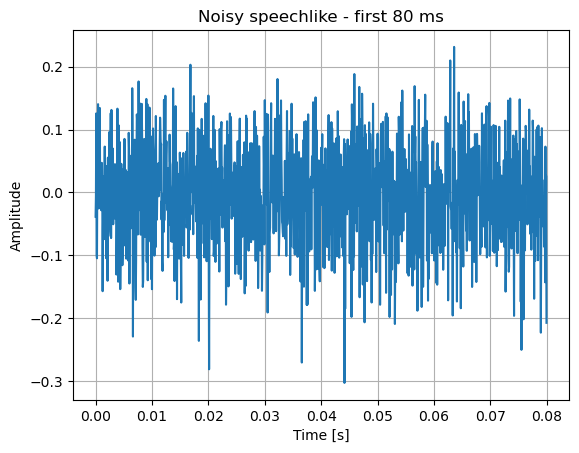

In [10]:
sr, x = load_wav(DATA_DIR/'noisy_speechlike_snr5.wav')
play(x, sr)
plot_time(x, sr, title='Noisy speechlike - first 80 ms', seconds=0.08)


### Task A (TODO)
Implement a moving average of length M.
Try M = 5, 15, 51.


M= 5


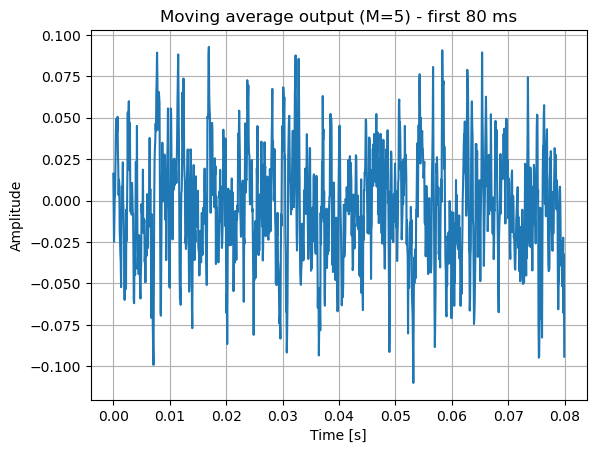

M= 15


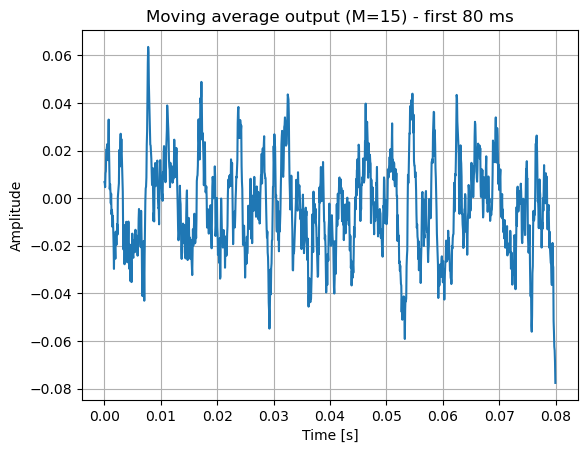

M= 51


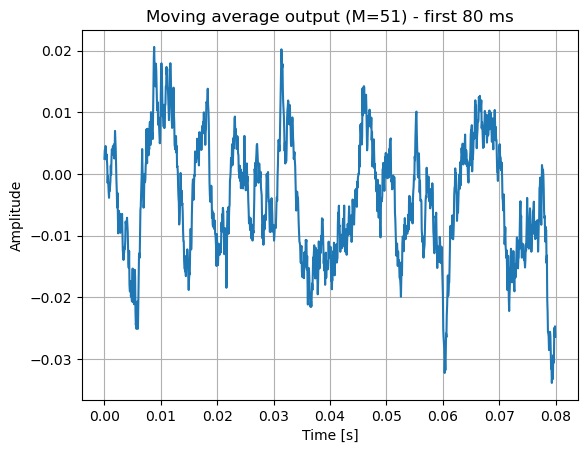

In [11]:
def moving_average(x, M):
    h = np.ones(M)/M
    return np.convolve(x, h, mode='same')

for M in [5, 15, 51]:
    y = moving_average(x, M)
    print('M=', M)
    play(y, sr)
    plot_time(y, sr, title=f'Moving average output (M={M}) - first 80 ms', seconds=0.08)


## 3.3 Frequency-domain filtering on short signals. Effects of aliasing

In [12]:
# --- Fixed "short" signal and filter (edit these if you like) ---
fs = 64.0          # Hz (only used to label frequency axis nicely)
f0 = 10.0          # sinusoid frequency (Hz)
Nx = 16            # signal length
M  = 7             # moving-average length (causal), Nh = M

n = np.arange(Nx)
x = np.sin(2*np.pi*f0*n/fs)

h = np.ones(M)/M
Nh = len(h)

# For comparison (linear convolution ground truth)
y_lin = np.convolve(x, h)  # length Nx+Nh-1

def _pad_to_N(v, N):
    """Zero-pad 1D array v to length N (N >= len(v))."""
    out = np.zeros(N, dtype=float)
    out[:len(v)] = v
    return out

def demo_circular_convolution(pad_extra):
    # DFT length N = max(Nx, Nh) + pad_extra
    Nmin = max(Nx, Nh)
    N = Nmin + pad_extra

    xN = _pad_to_N(x, N)
    hN = _pad_to_N(h, N)

    # DFTs
    X = np.fft.fft(xN, N)
    H = np.fft.fft(hN, N)

    # Circular convolution via IDFT of product
    y_circ = np.fft.ifft(X * H).real  # length N (circular)

    # Frequency axis (0..fs)
    f = np.arange(N) * (fs / N)

    # --- Plotting ---
    plt.figure(figsize=(12, 9))

    # 1) Signal: original and zero-padded
    ax1 = plt.subplot(2, 2, 1)
    ax1.stem(np.arange(Nx), x, basefmt=" ",  label="x[n] (original)")
    ax1.stem(np.arange(N), xN, basefmt=" ", markerfmt="C1o", linefmt="C1-",
             label=f"x[n] padded to N={N}")
    ax1.set_title("Signal (original vs zero-padded)")
    ax1.set_xlabel("n")
    ax1.set_ylabel("Amplitude")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="upper right")

    # 2) Filter: original and zero-padded
    ax2 = plt.subplot(2, 2, 2)
    ax2.stem(np.arange(Nh), h, basefmt=" ", label="h[n] (original)")
    ax2.stem(np.arange(N), hN, basefmt=" ", markerfmt="C1o", linefmt="C1-",
             label=f"h[n] padded to N={N}")
    ax2.set_title("Filter (original vs zero-padded)")
    ax2.set_xlabel("n")
    ax2.set_ylabel("Amplitude")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper right")

    # 3) DFT magnitudes of padded signal and filter
    ax3 = plt.subplot(2, 2, 3)
    ax3.plot(f, np.abs(X), label="|X[k]|")
    ax3.plot(f, np.abs(H), label="|H[k]|")
    ax3.set_title("DFT magnitudes (padded to N)")
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("Magnitude")
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc="upper right")
    ax3.set_xlim(0, fs)

    # 4) Output in time domain: circular conv (and optional linear reference)
    ax4 = plt.subplot(2, 2, 4)
    ax4.stem(np.arange(N), y_circ, basefmt=" ",  label="y_circ[n] (DFT/IDFT)")

    # Overlay the (zero-padded) linear convolution for reference
    y_lin_pad = _pad_to_N(y_lin, N) if N >= len(y_lin) else y_lin[:N]
    ax4.plot(np.arange(len(y_lin_pad)), y_lin_pad, "--", label="y_lin[n] (reference, truncated/padded)")

    # Condition for no time-aliasing: N >= Nx+Nh-1
    N_needed = Nx + Nh - 1
    ok = (N >= N_needed)
    ax4.set_title(f"Output (time domain) — {'NO aliasing' if ok else 'TIME ALIASING (wrap-around)'}")
    ax4.set_xlabel("n")
    ax4.set_ylabel("Amplitude")
    ax4.grid(True, alpha=0.3)
    ax4.legend(loc="upper right")

    # Short annotation
    msg = f"N = {N}, required for linear conv: Nx+Nh-1 = {N_needed}"
    plt.suptitle(msg, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# Slider: extra zeros beyond Nmin = max(Nx, Nh)
pad_slider = widgets.IntSlider(
    value=0, min=0, max=64, step=1,
    description="pad_extra",
    continuous_update=False,
    style={"description_width": "initial"},
)

ui = widgets.VBox([
    widgets.HTML(
        "<b>Circular convolution via DFT:</b> increase <code>pad_extra</code> until "
        "<code>N ≥ Nx+Nh-1</code> to remove time aliasing."
    ),
    pad_slider
])

out = widgets.interactive_output(demo_circular_convolution, {"pad_extra": pad_slider})
display(ui, out)


Output()

In [13]:
# ----------------------------
# Signal and filter definition
# ----------------------------
N = 16
a = 0.80
M = 5

n_x = np.arange(N)
x = (a ** n_x)

n_h = np.arange(M)
h = np.ones(M) / M

L_lin = N + M - 1

# ----------------------------
# Widgets
# ----------------------------
n0_slider = widgets.IntSlider(
    value=0, min=0, max=L_lin-1, step=1,
    description="n₀"
)

L_slider = widgets.IntSlider(
    value=L_lin, min=max(8, N, M), max=128, step=1,
    description="DFT L"
)

show_phase = widgets.Checkbox(value=False, description="Show phase")
show_alias = widgets.Checkbox(value=True, description="Show wrap-around error")

def update(n0, L, show_phase, show_alias):
    # Zero-padding
    x_pad = np.zeros(L)
    h_pad = np.zeros(L)
    x_pad[:N] = x
    h_pad[:M] = h

    # DFT-based convolution
    X = np.fft.fft(x_pad)
    H = np.fft.fft(h_pad)
    Y = X * H
    y_dft = np.fft.ifft(Y).real

    # True linear convolution
    y_lin = np.convolve(x, h, mode="full")

    # Fold linear convolution modulo L
    y_fold = np.zeros(L)
    for i, val in enumerate(y_lin):
        y_fold[i % L] += val

    # Wrap-around error
    error = y_dft - y_fold

    # Number of plots
    rows = 4 + int(show_phase) + int(show_alias)
    fig, axes = plt.subplots(rows, 1, figsize=(10, 3.2 * rows), constrained_layout=True)
    idx = 0

    # ---- Time-domain signals
    ax = axes[idx]; idx += 1
    ax.stem(n_x, x, basefmt=" ", label="x[n]")
    ax.stem(n_h, h, basefmt=" ",  label="h[n]")
    ax.set_title("Time-domain signals")
    ax.set_xlabel("n"); ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right")
    ax.set_xlim(-1, max(L, L_lin))

    # ---- |X[k]| and |H[k]|
    k = np.arange(L)
    ax = axes[idx]; idx += 1
    ax.plot(k, np.abs(X), label="|X[k]|")
    ax.plot(k, np.abs(H), label="|H[k]|")
    ax.set_title(f"DFT magnitudes (L={L})")
    ax.set_xlabel("k"); ax.set_ylabel("Magnitude")
    ax.legend(loc="upper right")
    ax.set_xlim(0, L-1)

    # ---- |Y[k]|
    ax = axes[idx]; idx += 1
    ax.plot(k, np.abs(Y))
    ax.set_title("|Y[k]| = |X[k]H[k]|")
    ax.set_xlabel("k"); ax.set_ylabel("Magnitude")
    ax.set_xlim(0, L-1)

    # ---- Phase (optional)
    if show_phase:
        ax = axes[idx]; idx += 1
        ax.plot(k, np.unwrap(np.angle(X)), label="∠X[k]")
        ax.plot(k, np.unwrap(np.angle(H)), label="∠H[k]")
        ax.plot(k, np.unwrap(np.angle(Y)), label="∠Y[k]")
        ax.set_title("Unwrapped phases")
        ax.set_xlabel("k"); ax.set_ylabel("Phase [rad]")
        ax.legend(loc="upper right")
        ax.set_xlim(0, L-1)

    # ---- Time-domain IFFT result
    ax = axes[idx]; idx += 1
    ax.stem(np.arange(L), y_dft, basefmt=" ", label="IFFT result")
    if 0 <= n0 < L:
        ax.plot(n0, y_dft[n0], "o", markersize=10)
    ax.set_title("Time-domain output from IDFT (circular convolution)")
    ax.set_xlabel("n"); ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right")
    ax.set_xlim(-1, L)

    # ---- Wrap-around error (optional)
    if show_alias:
        ax = axes[idx]
        ax.stem(np.arange(L), error, basefmt=" ")
        ax.set_title(
            "Wrap-around error:  y_circular[n] − folded y_linear[n]\n"
            "(zero when L ≥ N+M−1)"
        )
        ax.set_xlabel("n"); ax.set_ylabel("Error")
        ax.set_xlim(-1, L)

    plt.show()

widgets.interact(
    update,
    n0=n0_slider,
    L=L_slider,
    show_phase=show_phase,
    show_alias=show_alias
);

interactive(children=(IntSlider(value=0, description='n₀', max=19), IntSlider(value=20, description='DFT L', m…

## 3.4 Frequency-domain filtering (FFT notch)


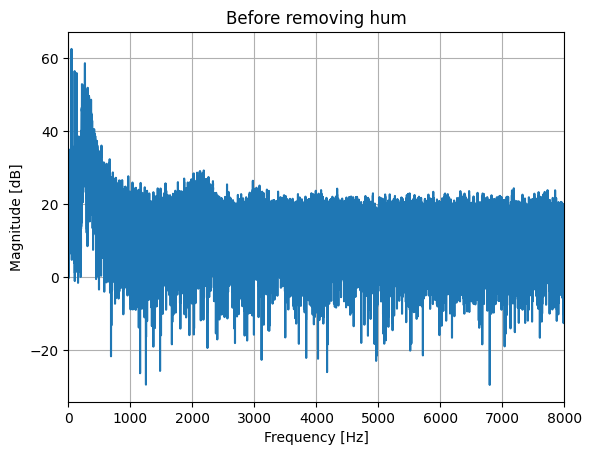

In [5]:
sr, x = load_wav(DATA_DIR/'speechlike_with_50hz_hum.wav')
play(x, sr)
plot_spectrum(x, sr, title='Before removing hum')


### Task B (TODO)
Remove 50 Hz and 100 Hz with a notch in the FFT domain.


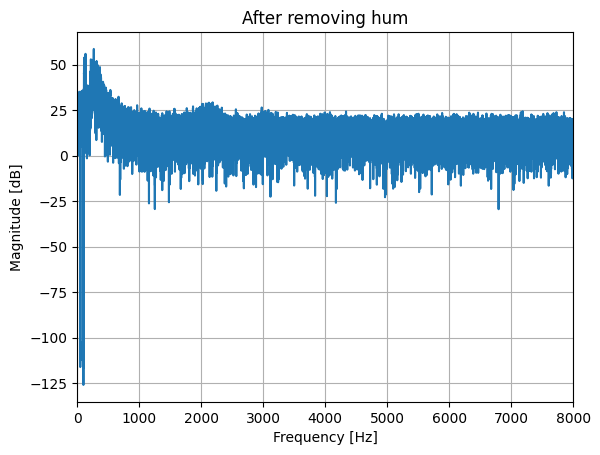

In [7]:
def notch_fft(x, sr, freqs=(50, 100), width_hz=3.0):
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x), d=1/sr)
    mask = np.ones_like(X, dtype=bool)
    for f0 in freqs:
        mask &= ~((f >= f0-width_hz) & (f <= f0+width_hz))
    y = np.fft.irfft(X * mask, n=len(x))
    return y

y = notch_fft(x, sr)
play(y, sr)
plot_spectrum(y, sr, title='After removing hum')
